In [ ]:
import numpy as np
import pandas as pd


In [ ]:
!pip install music21

In [ ]:
# Creating a function to read midi file 
from music21 import *

def midi_read(file):

  print("Reading file:",file)
  notes=[]
  notes_to_parse= None
  midi = converter.parse(file)
  
  s2 = instrument.partitionByInstrument(midi)

  for part in s2.parts:
  
      if 'Piano' in str(part): 
      
          notes_to_parse = part.recurse() 

          for element in notes_to_parse:
              
              if isinstance(element, note.Note):
                  notes.append(str(element.pitch))

              elif isinstance(element, chord.Chord):
                  notes.append('.'.join(str(n) for n in element.normalOrder))

  return np.array(notes)

In [ ]:
import os

#Array Processing
import numpy as np

#specify the path
path='/content/drive/MyDrive/schubert/'

#read all the filenames
files=[i for i in os.listdir(path) if i.endswith(".mid")]

#reading each midi file
notes_array = np.array([midi_read(path+i) for i in files])

Reading file: /content/drive/MyDrive/schubert/schu_143_3.mid
Reading file: /content/drive/MyDrive/schubert/schu_143_2.mid
Reading file: /content/drive/MyDrive/schubert/schu_143_1.mid
Reading file: /content/drive/MyDrive/schubert/schumm-5.mid
Reading file: /content/drive/MyDrive/schubert/schumm-6.mid
Reading file: /content/drive/MyDrive/schubert/schumm-2.mid
Reading file: /content/drive/MyDrive/schubert/schumm-3.mid
Reading file: /content/drive/MyDrive/schubert/schumm-4.mid
Reading file: /content/drive/MyDrive/schubert/schumm-1.mid
Reading file: /content/drive/MyDrive/schubert/schub_d960_4.mid
Reading file: /content/drive/MyDrive/schubert/schuim-4.mid
Reading file: /content/drive/MyDrive/schubert/schuim-3.mid
Reading file: /content/drive/MyDrive/schubert/schuim-1.mid
Reading file: /content/drive/MyDrive/schubert/schuim-2.mid
Reading file: /content/drive/MyDrive/schubert/schub_d960_3.mid
Reading file: /content/drive/MyDrive/schubert/schub_d960_2.mid
Reading file: /content/drive/MyDrive/s

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  del sys.path[0]


In [ ]:
#converting 2D array into 1D array
notes_ = [element for note_ in notes_array for element in note_]

#No. of unique notes
unique_notes = list(set(notes_))
print(len(unique_notes))

304


Text(0, 0.5, 'Frequency')

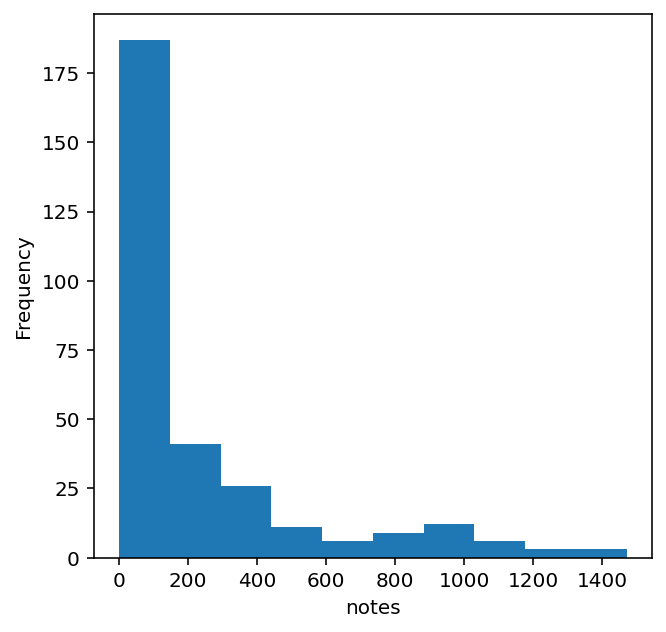

In [ ]:
#importing library
from collections import Counter

#computing frequency of each note
freq = dict(Counter(notes_))

#library for visualiation
import matplotlib.pyplot as plt

#consider only the frequencies
no=[count for _,count in freq.items()]

#set the figure size
plt.figure(figsize=(5,5))

#plot
plt.hist(no)
plt.xlabel("notes")
plt.ylabel("Frequency")

In [ ]:
# As most notes have a frequency above 50 keeping only those
frequent_notes = [note_ for note_, count in freq.items() if count>=50]
print(len(frequent_notes))

167


In [ ]:
new_music=[]

for notes in notes_array:
    temp=[]
    for note_ in notes:
        if note_ in frequent_notes:
            temp.append(note_)            
    new_music.append(temp)
    
new_music = np.array(new_music)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
no_of_timesteps = 32
x = []
y = []

for note_ in new_music:
    for i in range(0, len(note_) - no_of_timesteps, 1):
        
        #preparing input and output sequences
        input_ = note_[i:i + no_of_timesteps]
        output = note_[i + no_of_timesteps]
        
        x.append(input_)
        y.append(output)
        
x=np.array(x)
y=np.array(y)

In [ ]:
unique_x = list(set(x.ravel()))
x_note_to_int = dict((note_, number) for number, note_ in enumerate(unique_x))

In [ ]:
#preparing input sequences
x_seq=[]
for i in x:
    temp=[]
    for j in i:
        #assigning unique integer to every note
        temp.append(x_note_to_int[j])
    x_seq.append(temp)
    
x_seq = np.array(x_seq)

In [ ]:
unique_y = list(set(y))
y_note_to_int = dict((note_, number) for number, note_ in enumerate(unique_y)) 
y_seq=np.array([y_note_to_int[i] for i in y])

In [ ]:
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(x_seq,y_seq,test_size=0.2,random_state=0)

In [ ]:
from keras.layers import (Dense,Flatten,Conv1D,Embedding,MaxPool1D,Dropout,GlobalMaxPool1D)
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
# import keras.backend as K

# K.clear_session()
model = Sequential()
    
#embedding layer
model.add(Embedding(len(unique_x), 100, input_length=32,trainable=True)) 

model.add(Conv1D(64,3, padding='causal',activation='relu'))
model.add(Dropout(0.2))
model.add(MaxPool1D(2))
    
model.add(Conv1D(128,3,activation='relu',dilation_rate=2,padding='causal'))
model.add(Dropout(0.2))
model.add(MaxPool1D(2))

model.add(Conv1D(256,3,activation='relu',dilation_rate=4,padding='causal'))
model.add(Dropout(0.2))
model.add(MaxPool1D(2))
          
#model.add(Conv1D(256,5,activation='relu'))    
model.add(GlobalMaxPool1D())
    
model.add(Dense(256, activation='relu'))
model.add(Dense(len(unique_y), activation='softmax'))
    
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam',metrics=['acc'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 32, 100)           16700     
_________________________________________________________________
conv1d (Conv1D)              (None, 32, 64)            19264     
_________________________________________________________________
dropout (Dropout)            (None, 32, 64)            0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 16, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 16, 128)           24704     
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 128)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 8, 128)            0

In [ ]:
mc=ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', save_best_only=True,verbose=1)

In [ ]:
history = model.fit(np.array(x_tr),np.array(y_tr),batch_size=128,epochs=500, validation_data=(np.array(x_val),np.array(y_val)),verbose=1, callbacks=[mc])

Epoch 1/500
403/403 [==============================] - 20s 11ms/step - loss: 4.6075 - acc: 0.0337 - val_loss: 4.0412 - val_acc: 0.0938

Epoch 00001: val_acc improved from -inf to 0.09384, saving model to best_model.h5
Epoch 2/500
403/403 [==============================] - 3s 9ms/step - loss: 3.8341 - acc: 0.0996 - val_loss: 3.7896 - val_acc: 0.1243

Epoch 00002: val_acc improved from 0.09384 to 0.12427, saving model to best_model.h5
Epoch 3/500
403/403 [==============================] - 3s 9ms/step - loss: 3.6421 - acc: 0.1259 - val_loss: 3.6893 - val_acc: 0.1348

Epoch 00003: val_acc improved from 0.12427 to 0.13475, saving model to best_model.h5
Epoch 4/500
403/403 [==============================] - 3s 9ms/step - loss: 3.5063 - acc: 0.1434 - val_loss: 3.5963 - val_acc: 0.1517

Epoch 00004: val_acc improved from 0.13475 to 0.15167, saving model to best_model.h5
Epoch 5/500
403/403 [==============================] - 3s 9ms/step - loss: 3.3855 - acc: 0.1590 - val_loss: 3.5338 - val_acc:

In [ ]:
#loading best model
from keras.models import load_model
model = load_model('best_model.h5')

In [ ]:
import random
ind = np.random.randint(0,len(x_val)-1)

random_music = x_val[ind]

predictions=[]
for i in range(10):

    random_music = random_music.reshape(1,no_of_timesteps)

    prob  = model.predict(random_music)[0]
    y_pred= np.argmax(prob,axis=0)
    predictions.append(y_pred)

    random_music = np.insert(random_music[0],len(random_music[0]),y_pred)
    random_music = random_music[1:]
    
print(predictions)

[150, 76, 150, 117, 140, 140, 140, 140, 140, 76]


In [ ]:
x_int_to_note = dict((number, note_) for number, note_ in enumerate(unique_x)) 
predicted_notes = [x_int_to_note[i] for i in predictions]

In [ ]:
def convert_to_midi(prediction_output):
   
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model
    for pattern in prediction_output:
        
        # pattern is a chord
        if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                
                cn=int(current_note)
                new_note = note.Note(cn)
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
                
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
            
        # pattern is a note
        else:
            
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            output_notes.append(new_note)

        # increase offset each iteration so that notes do not stack
        offset += 1
    midi_stream = stream.Stream(output_notes)
    midi_stream.write('midi', fp='music.mid')

In [ ]:
convert_to_midi(predicted_notes)